Transfer learning with ResNet Model. However, this model is not pretrained at all for a baseline.

Import libraries

In [1]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import torchvision
from torch import nn

# For plotting and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            f1_score, precision_score, recall_score, roc_auc_score

import pandas as pd
import numpy as np

Load CIFAR10

In [2]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((256,256)),
])

In [3]:
# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=False)

100%|██████████| 170M/170M [00:05<00:00, 31.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# Get class labels
classes = []
class_idx = []
for key, val in trainset.class_to_idx.items():
  classes.append(key)
  class_idx.append(val)
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Download ResNet model and replace last fully connected layer.

In [5]:
# Define ResNet model
model = torchvision.models.resnet18(pretrained=False)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# Replace fully connected layer with new layer that has 10 outputs for CIFAR10
model.fc = nn.Linear(512, 10)

Define Loss and optimizer

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Train the model

In [8]:
%%time
# Training the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

n_epoch=10

# Initialize loss and accuracies
loss_epoch=[]
train_acc_epoch=[]
test_acc_epoch=[]

for epoch in range(n_epoch):  # Loop over the dataset multiple times
    print(f'epoch {epoch}')
    running_loss = 0.0
    batches = 0.0
    correct = 0.0
    total = 0.0
    correct_test = 0
    total_test = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels) # Compute loss
        loss.backward() # Backpropagation
        optimizer.step() # Update weights

        # Calculate the loss
        running_loss += loss.item()
        batches += 1
        total += labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

    # Testing the model
    with torch.no_grad(): # Don't update weights when testing
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Print loss for given epoch
    print('loss: %.3f' %
          (running_loss / batches))
    print(f'Train accuracy: {100 * correct / total}')
    print(f'Test accuracy: {100 * correct_test / total_test}')

    loss_epoch.append(running_loss / batches)
    train_acc_epoch.append(100 * correct / total)
    test_acc_epoch.append(100 * correct_test / total_test)

    # Delete loss, outputs to make sure RAM stays stable.
    del running_loss, correct, correct_test, outputs

    # Stop early if test accuracy is less than the last two epochs
    if epoch >= 2:
      if test_acc_epoch[epoch] < test_acc_epoch[epoch-2] and test_acc_epoch[epoch] < test_acc_epoch[epoch-1]:
        break

print('Finished Training')

epoch 0
loss: 1.508
Train accuracy: 44.456
Test accuracy: 56.5
epoch 1
loss: 1.012
Train accuracy: 63.742
Test accuracy: 67.89
epoch 2
loss: 0.746
Train accuracy: 73.46
Test accuracy: 73.69
epoch 3
loss: 0.564
Train accuracy: 80.132
Test accuracy: 77.72
epoch 4
loss: 0.433
Train accuracy: 84.904
Test accuracy: 78.6
epoch 5
loss: 0.316
Train accuracy: 88.952
Test accuracy: 79.26
epoch 6
loss: 0.203
Train accuracy: 93.138
Test accuracy: 79.69
epoch 7
loss: 0.121
Train accuracy: 96.004
Test accuracy: 80.66
epoch 8
loss: 0.076
Train accuracy: 97.554
Test accuracy: 80.5
epoch 9
loss: 0.040
Train accuracy: 98.818
Test accuracy: 81.05
Finished Training
CPU times: user 40min 5s, sys: 4min 55s, total: 45min
Wall time: 44min 27s


Plot the results

Text(0.5, 0, 'Epoch')

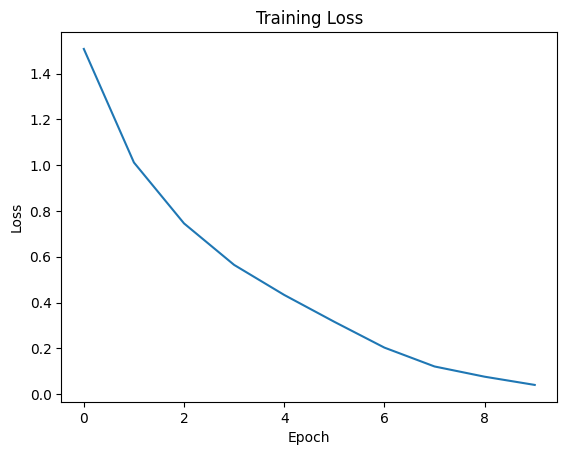

In [9]:
# Loss
plt.plot([i for i in range(len(loss_epoch))],loss_epoch)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

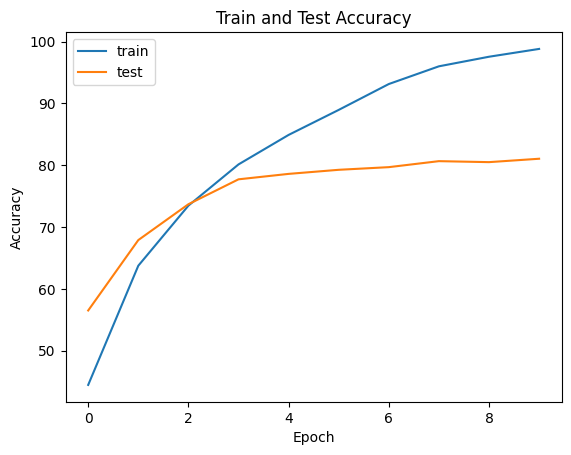

In [10]:
# Accuracy
plt.plot([i for i in range(len(train_acc_epoch))],train_acc_epoch,label='train')
plt.plot([i for i in range(len(test_acc_epoch))],test_acc_epoch,label='test')
plt.legend()
plt.title('Train and Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

Test accuracy tops out at about 80%. This is worse than using the pretrained model which shows the pretrained model that is retuned is able to extract more features valuable for classifying these images than just a model trained on this small dataset. This shows the value in transfer learning.

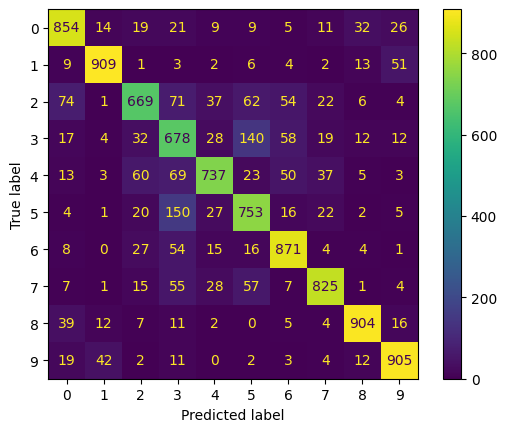

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
# Confusion matrix
all_labels=[]
pred=[]
with torch.no_grad(): # Don't update weights when testing
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels = all_labels + labels.tolist()
        pred = pred + predicted.tolist()

cm = confusion_matrix(all_labels, pred)
ConfusionMatrixDisplay(cm).plot()
plt.show()

classes

Get metrics

In [12]:
f1 = f1_score(all_labels,pred,average=None)
prec = precision_score(all_labels,pred,average=None)
rec = recall_score(all_labels,pred,average=None)

metrics = pd.DataFrame(np.array([f1,prec,rec]).T,index=classes,columns=['F1','Precision','Recall'])
metrics

,F1,Precision,Recall
airplane,0.835616,0.818008,0.854
automobile,0.914947,0.920973,0.909
bird,0.722462,0.785211,0.669
cat,0.638719,0.603740,0.678
deer,0.781963,0.832768,0.737
dog,0.728240,0.705056,0.753
frog,0.840328,0.811743,0.871
horse,0.846154,0.868421,0.825
ship,0.908086,0.912210,0.904
truck,0.892945,0.881207,0.905


Save output

In [ ]:
save=False
if save:
  import pandas as pd

  torch.save(model.state_dict(),'ResNet_CIFAR10_NoPretrainedLayers_weights.pth')
  values=pd.DataFrame({'loss':loss_epoch,'train_acc':train_acc_epoch,'test_acc':test_acc_epoch})
  values.to_csv('NoPretrainedLayers_accuracy.csv',index=False)
  metrics.to_csv('NoPretrainedLayers_metrics.csv')
  values